# Data Mining Final Project 2021 - 2022
## Authors: Beatriz Gonçalves (m20210695), Diogo Hipólito (m20210633) and Diogo Pereira (m20210657)

# 1) Introduction

The client, a Marketing Department from an an insurance company, wishes to better understand the scope of its clients, in order to better serve them and increase their ROI (Return On Investment). The group was given an ABT (Analytic Based Table), consisting of 10.290 customers and given the task of analyzing the table for evident groups of clusters, extracting the behaviour of said clusters and provide insights on how to better serve them.

The project is contained within a Github repository which can be accessed through the following link: https://github.com/beatrizctgoncalves/project_dm. This repository provides a Jupyter Notebook with all the relevant analysis and a report that summarizes the work done. Note that these two documents should be used together as they complement each other.

## 1.1) Importing Packages

In [1]:
# Required imports for the project
#pip install sas7bdat

from sas7bdat import SAS7BDAT
import numpy as np
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
from math import ceil

# 2) Importing and Assessing Data

In [2]:
df_insurance = pd.read_sas('a2z_insurance.sas7bdat')
conn = sqlite3.connect('a2z_insurance.db')
cursor = conn.cursor()

# Build Analytical Base Table (ABT)
df_insurance.to_sql(name='file', con=conn, if_exists='replace', index=False)

In [3]:
# Dataset head
df_insurance.head()

,CustID,FirstPolYear,BirthYear,EducDeg,MonthSal,GeoLivArea,Children,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork
0,1.0,1985.0,1982.0,b'2 - High School',2177.0,1.0,1.0,380.97,0.39,375.85,79.45,146.36,47.01,16.89
1,2.0,1981.0,1995.0,b'2 - High School',677.0,4.0,1.0,-131.13,1.12,77.46,416.20,116.69,194.48,106.13
2,3.0,1991.0,1970.0,b'1 - Basic',2277.0,3.0,0.0,504.67,0.28,206.15,224.50,124.58,86.35,99.02
3,4.0,1990.0,1981.0,b'3 - BSc/MSc',1099.0,4.0,1.0,-16.99,0.99,182.48,43.35,311.17,35.34,28.34
4,5.0,1986.0,1973.0,b'3 - BSc/MSc',1763.0,4.0,1.0,35.23,0.90,338.62,47.80,182.59,18.78,41.45


In [4]:
# Get dimension of the dataset
df_insurance.shape

(10296, 14)

In [5]:
# Data types of the variables
df_insurance.dtypes

CustID           float64
FirstPolYear     float64
BirthYear        float64
EducDeg           object
MonthSal         float64
GeoLivArea       float64
Children         float64
CustMonVal       float64
ClaimsRate       float64
PremMotor        float64
PremHousehold    float64
PremHealth       float64
PremLife         float64
PremWork         float64
dtype: object

In [6]:
# Fix some wrong data types
df_insurance['CustID'] = (df_insurance['CustID'].astype(float)).astype(int)
df_insurance = df_insurance.astype({"GeoLivArea": object, "Children": object})

In [7]:
# Count missing values
df_insurance.isna().sum()

CustID             0
FirstPolYear      30
BirthYear         17
EducDeg           17
MonthSal          36
GeoLivArea         1
Children          21
CustMonVal         0
ClaimsRate         0
PremMotor         34
PremHousehold      0
PremHealth        43
PremLife         104
PremWork          86
dtype: int64

In [8]:
# Check duplicates
df_insurance.duplicated().sum()

0

In [9]:
# Frequencies of missing values across rows
df_insurance.isna().apply(lambda x:sum(x), axis=1).value_counts().sort_index()

0    9987
1     256
2      38
3       3
4      12
dtype: int64

In [10]:
# Get summary statistics from the dataframe
df_insurance.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
CustID,10296.0,NaN,NaN,NaN,5148.5,2972.34352,1.0,2574.75,5148.5,7722.25,10296.0
FirstPolYear,10266.0,NaN,NaN,NaN,1991.062634,511.267913,1974.0,1980.0,1986.0,1992.0,53784.0
BirthYear,10279.0,NaN,NaN,NaN,1968.007783,19.709476,1028.0,1953.0,1968.0,1983.0,2001.0
EducDeg,10279,4,b'3 - BSc/MSc',4799,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MonthSal,10260.0,NaN,NaN,NaN,2506.667057,1157.449634,333.0,1706.0,2501.5,3290.25,55215.0
GeoLivArea,10295.0,4.0,4.0,4145.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Children,10275.0,2.0,1.0,7262.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CustMonVal,10296.0,NaN,NaN,NaN,177.892605,1945.811505,-165680.42,-9.44,186.87,399.7775,11875.89
ClaimsRate,10296.0,NaN,NaN,NaN,0.742772,2.916964,0.0,0.39,0.72,0.98,256.2
PremMotor,10262.0,NaN,NaN,NaN,300.470252,211.914997,-4.11,190.59,298.61,408.3,11604.42


In [11]:
# More info about the dataframe
df_insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10296 entries, 0 to 10295
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CustID         10296 non-null  int64  
 1   FirstPolYear   10266 non-null  float64
 2   BirthYear      10279 non-null  float64
 3   EducDeg        10279 non-null  object 
 4   MonthSal       10260 non-null  float64
 5   GeoLivArea     10295 non-null  object 
 6   Children       10275 non-null  object 
 7   CustMonVal     10296 non-null  float64
 8   ClaimsRate     10296 non-null  float64
 9   PremMotor      10262 non-null  float64
 10  PremHousehold  10296 non-null  float64
 11  PremHealth     10253 non-null  float64
 12  PremLife       10192 non-null  float64
 13  PremWork       10210 non-null  float64
dtypes: float64(10), int64(1), object(3)
memory usage: 1.1+ MB


## 2.1) Visual Exploration

In [16]:
# Define metric and non-metric datasets
non_metric_features = df_insurance.loc[:, (df_insurance.columns=="CustID") | (np.array(df_insurance.dtypes=="object"))]
metric_features = df_insurance.loc[:, (df_insurance.columns=="CustID") | (np.array(df_insurance.dtypes=="float64"))]

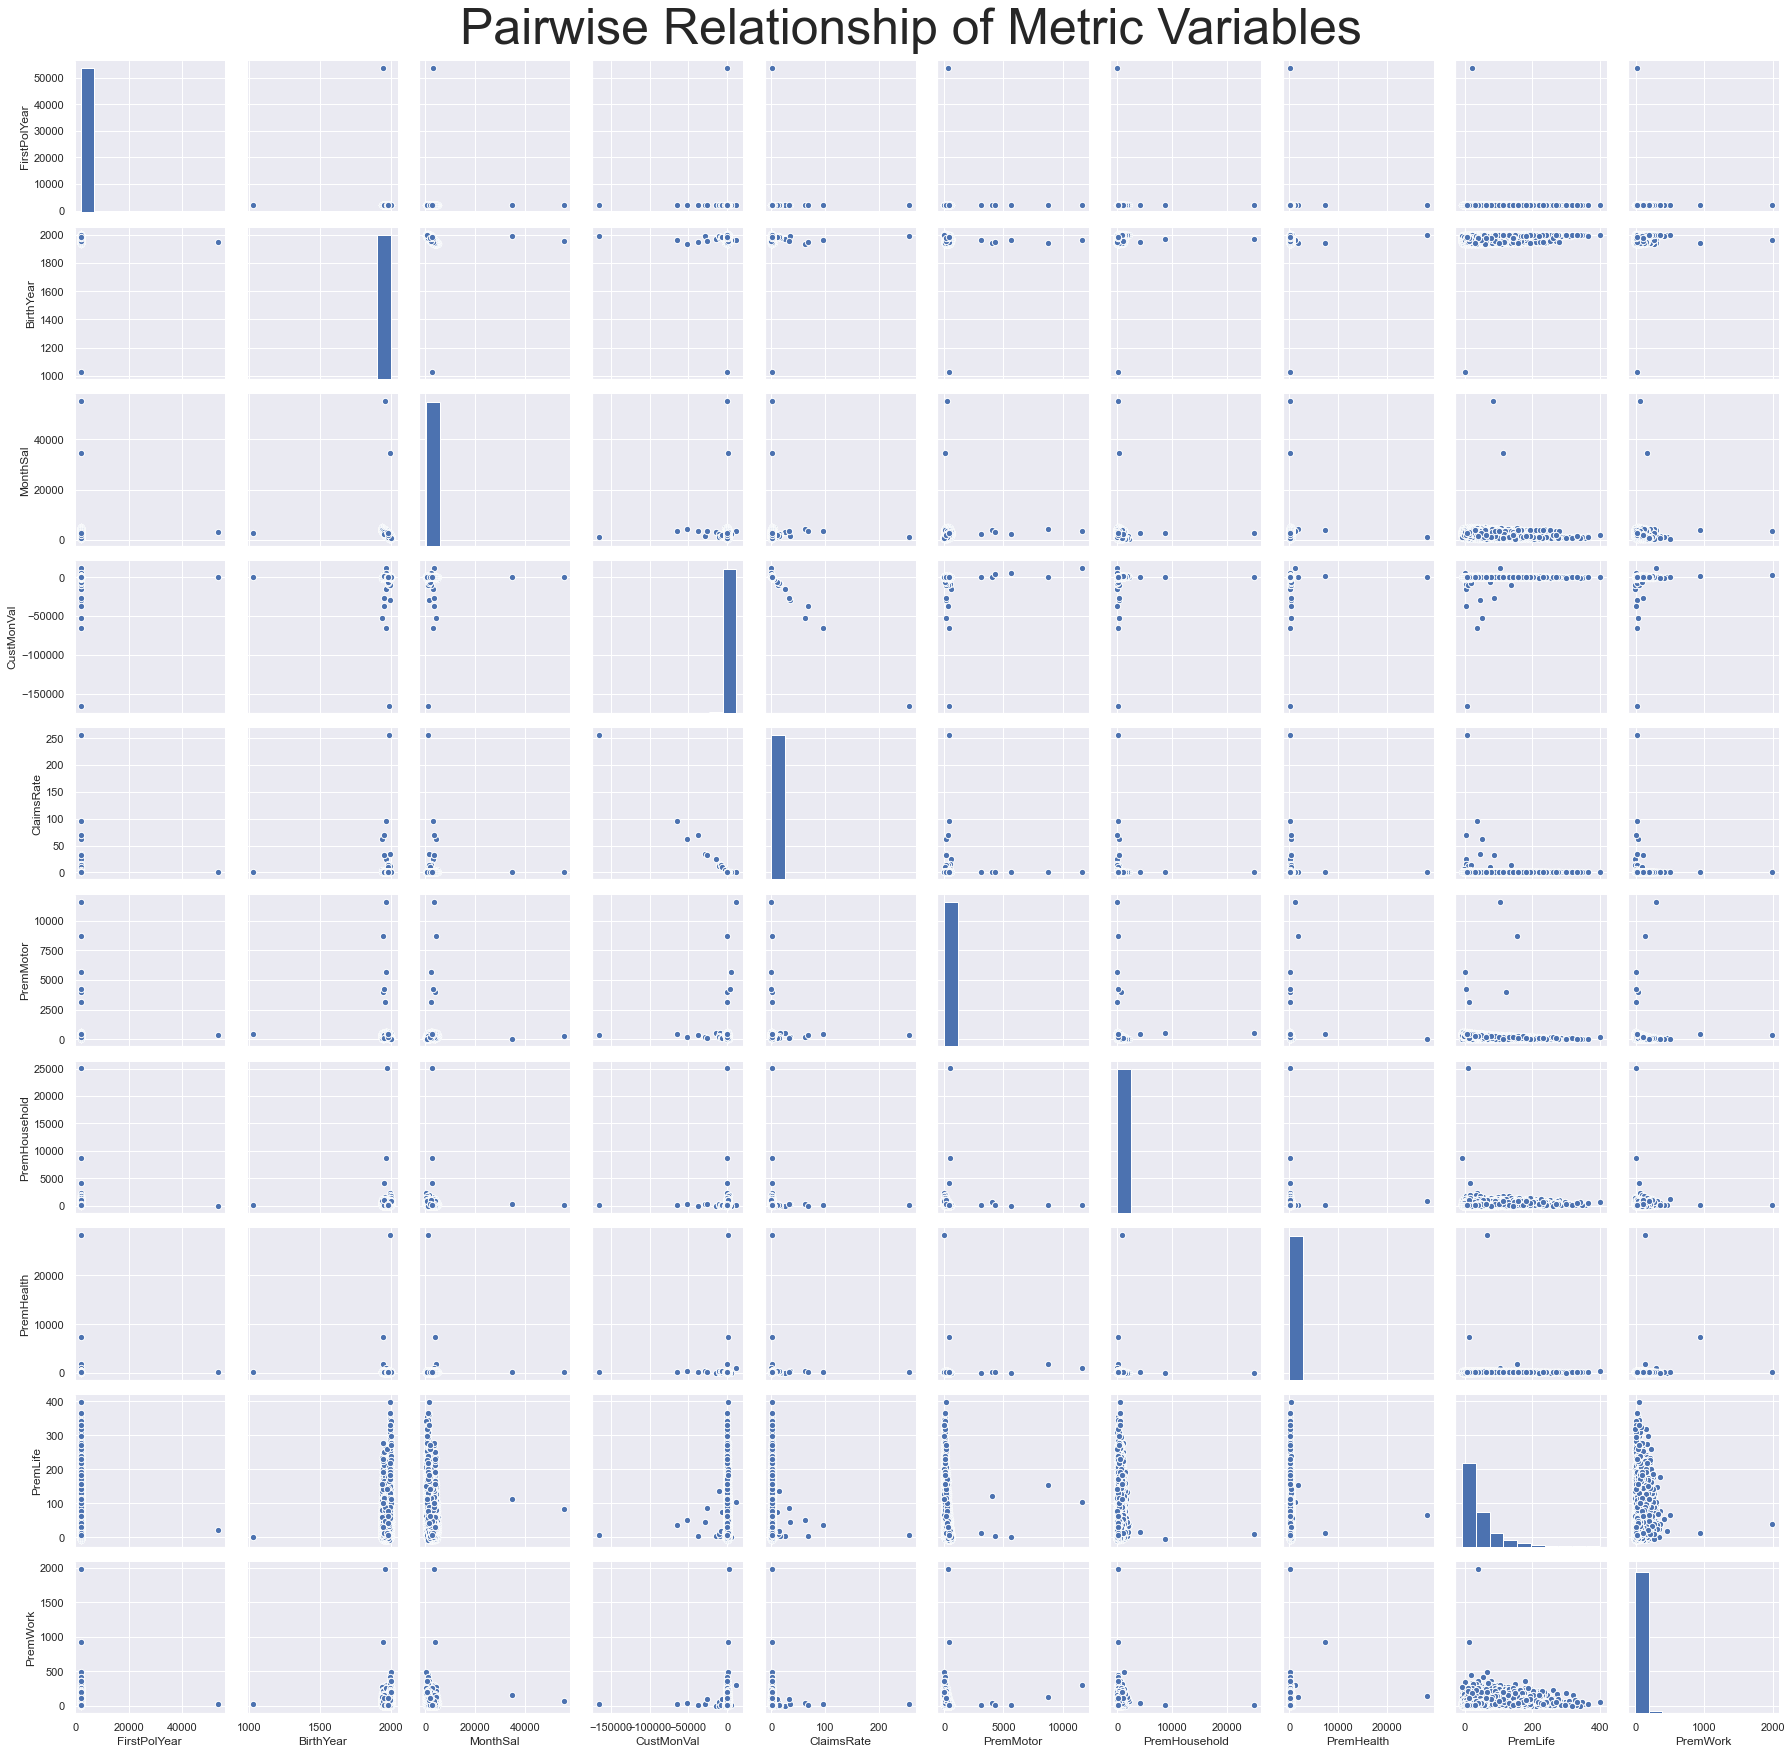

In [19]:
# Pairwise Relationship of Metric Variables in one figure
sns.set()

# Prepare figure
# Set PairGrid:
g = sns.PairGrid(metric_features.drop('CustID', 1).dropna())

# Plot data
# Populating PairGrid:
mdg = g.map_diag(plt.hist, edgecolor="w")
mog = g.map_offdiag(plt.scatter, edgecolor="w", s=40)

# Layout
# Add a centered title to the figure:
plt.subplots_adjust(top=0.95)
title = "Pairwise Relationship of Metric Variables"
plt.suptitle(title, fontsize=50)

plt.show()

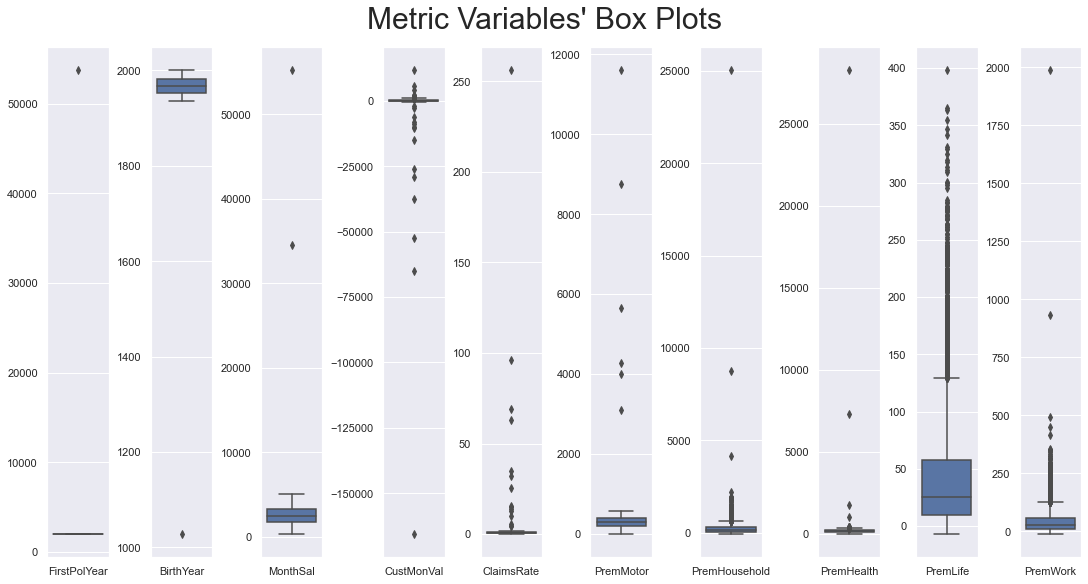

In [20]:
# All Metric Variables' Box Plots in one figure
sns.set()

# Prepare figure
# Prepare dataframe layout:
data = metric_features.melt('CustID')
plot_features = metric_features.drop('CustID', 1).columns
#Prepare figure layout:
fig, axes = plt.subplots(1, len(plot_features), figsize=(15, 8), constrained_layout=True)

# Plot data
# Draw the box plots:
for i in zip(axes, plot_features):
    sns.boxplot(x="variable", y="value", data=data.loc[data["variable"]==i[1]], ax=i[0])
    i[0].set_xlabel("")
    i[0].set_ylabel("")

# Layout
# Add a centered title to the figure:
title = "Metric Variables' Box Plots"
plt.suptitle(title, fontsize=30)

plt.show()

### 2.1.1) Categorical/Low Cardinality Variables' Absolute Frequencies

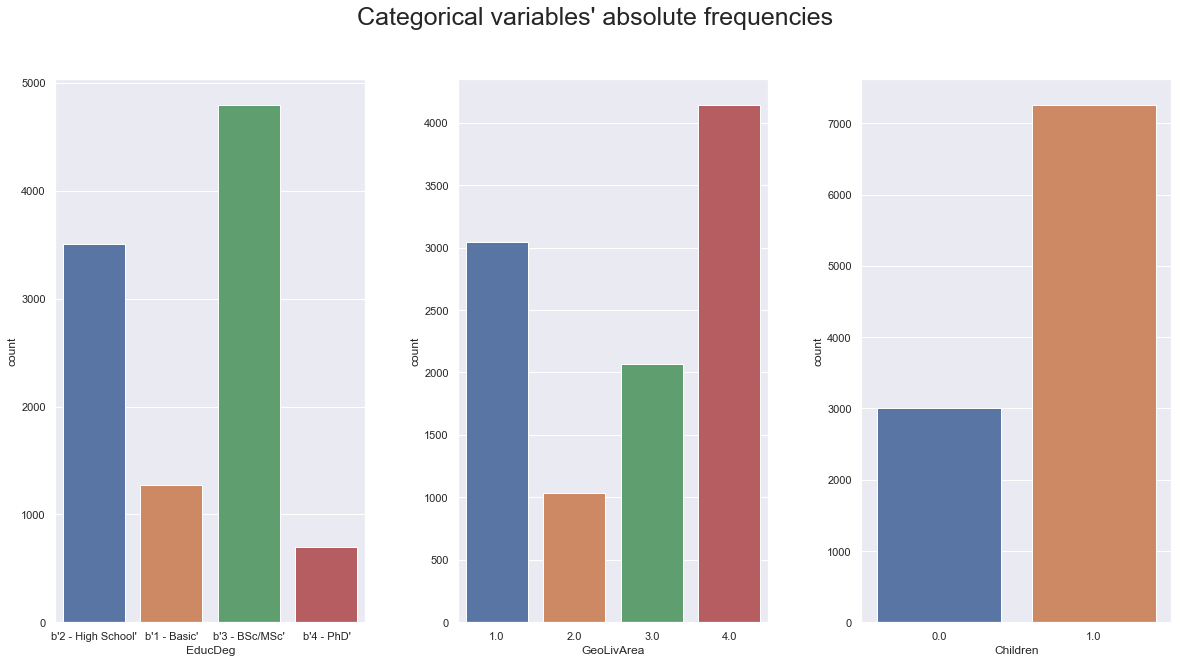

In [29]:
# All Non-Metric variable bar plot
sns.set() # Reset our formatting defaults

# Prepare figure. Create individual axes where each bar plot will be placed
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))

# Plot data
# Iterate across axes objects and associate each bar plot (hint: use the ax argument):
sns.countplot(x=df_insurance["EducDeg"], data=non_metric_features, ax=ax1)
sns.countplot(x=df_insurance["GeoLivArea"], data=non_metric_features, ax=ax2)
sns.countplot(x=df_insurance["Children"], data=non_metric_features, ax=ax3)

# Layout
plt.subplots_adjust(wspace=0.3)
title = "Categorical variables' absolute frequencies"
plt.suptitle(title, fontsize=25)

plt.show()

### 2.1.2) Metric Variables' Correlation Matrix

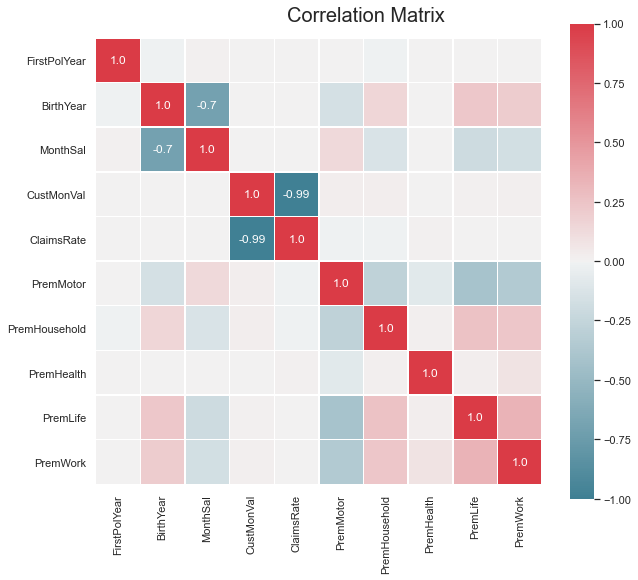

In [37]:
# Prepare figure
fig = plt.figure(figsize=(10, 8))

# Obtain correlation matrix. Round the values to 2 decimal cases. Use the DataFrame corr() and round() method.
corr = np.round(df_insurance[metric_features.columns].drop('CustID', 1).corr(method="pearson"), decimals=2)

# Build annotation matrix (values above |0.5| will appear annotated in the plot)
mask_annot = np.absolute(corr.values) >= 0.5
annot = np.where(mask_annot, corr.values, np.full(corr.shape,"")) # Try to understand what this np.where() does

# Plot heatmap of the correlation matrix
sns.heatmap(data=corr, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

# Layout
fig.subplots_adjust(top=0.95)
title = "Correlation Matrix"
fig.suptitle(title, fontsize=20)

plt.show()